In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import cycle

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.linear_model import Ridge, Lasso
from statsmodels.graphics.tsaplots import plot_acf

from datetime import date
import holidays

from fbprophet import Prophet
import pmdarima
import time
#plt.style.use('ggplot')

In [2]:
it_df = pd.read_csv('../data/it.csv', sep = ',')

In [3]:
it_df.head(5)

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,23126.0
1,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,21534.0
2,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,20219.0
3,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,19470.0
4,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,19485.0


In [4]:
it_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48936 entries, 0 to 48935
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   48936 non-null  object 
 1   end     48936 non-null  object 
 2   load    48936 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [5]:
it_df = it_df.drop(columns='end').set_index('start')

In [6]:
it_df.index = pd.to_datetime(it_df.index)
it_df.index.dtype

datetime64[ns, UTC]

In [7]:
it_df.index.name = "time"

In [8]:
it_df.rename(columns = {'load': 'Megawatt'}, inplace=True)

In [9]:
start_date = it_df.iloc[0].name
print('Start Date :', start_date)
end_date = it_df.iloc[-1].name
print('End Date :', end_date)
corona_start = it_df.iloc[-4320].name
print('Corona Virus starts =', corona_start)

Start Date : 2015-01-01 00:00:00+00:00
End Date : 2020-07-31 23:00:00+00:00
Corona Virus starts = 2020-02-03 00:00:00+00:00


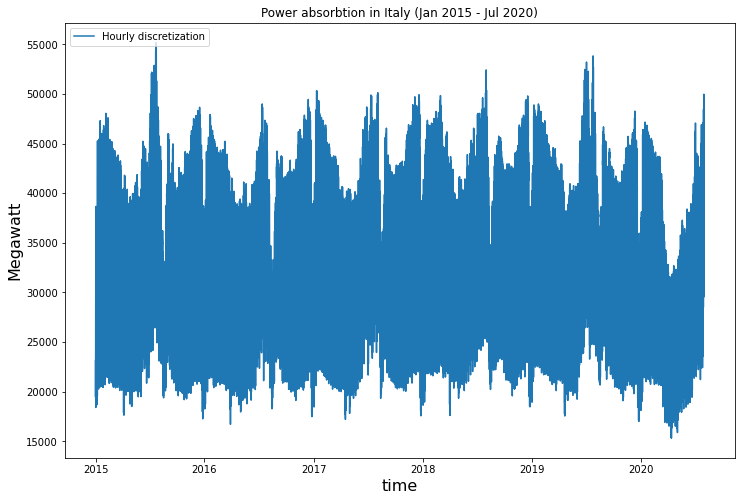

In [10]:
fig, ax = plt.subplots(1, figsize=(12,8))
with plt.style.context('dark_background'):
    ax.plot(it_df, label="Hourly discretization")
    ax.title.set_text('Power absorbtion in Italy (Jan 2015 - Jul 2020)')
    ax.set_xlabel('time', size = 16)
    ax.set_ylabel('Megawatt', size=16)
plt.legend(loc='upper left')


### Removing values after february because of beginning of corona crisis

In [11]:
it_df = it_df.loc[start_date:corona_start]

In [12]:
it_df.mean()

Megawatt    33196.262053
dtype: float64

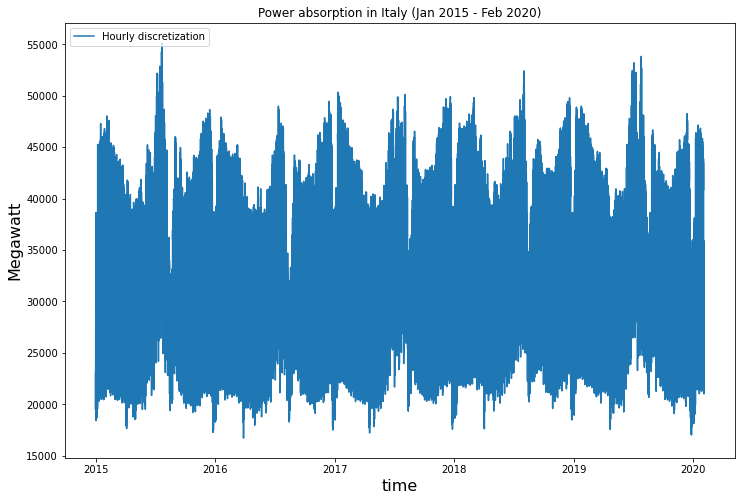

In [13]:
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(it_df, label="Hourly discretization")
ax.title.set_text('Power absorption in Italy (Jan 2015 - Feb 2020)')

ax.set_xlabel('time', size = 16)
ax.set_ylabel('Megawatt', size=16)
plt.legend(loc='upper left')

## Splitting in Training, Verification and Test data

In [14]:
y = it_df['Megawatt']
X = it_df[['Megawatt']]
y.shape, X.shape

((44617,), (44617, 1))

In [15]:
# training
y_train = y[start_date:'2018-05-31 23:00:00+00:00']
X_train = X[start_date:'2018-05-31 23:00:00+00:00']
print(y_train.shape, X_train.shape)


(29928,) (29928, 1)


## Exploratory Analysis

#### considering only the training portion of data for exploratory analysis

In [16]:
X_train


,Megawatt
time,
2015-01-01 00:00:00+00:00,23126.0
2015-01-01 01:00:00+00:00,21534.0
2015-01-01 02:00:00+00:00,20219.0
2015-01-01 03:00:00+00:00,19470.0
2015-01-01 04:00:00+00:00,19485.0
...,...
2018-05-31 19:00:00+00:00,38636.0
2018-05-31 20:00:00+00:00,35703.0
2018-05-31 21:00:00+00:00,32751.0


In [17]:
len(X_train)

29928

In [18]:
#### Filtering the training data to find some trend and seaonality

In [19]:
tP_res_W = X_train.resample('W').transform('mean').ffill()

In [20]:
len(tP_res_W)

29928

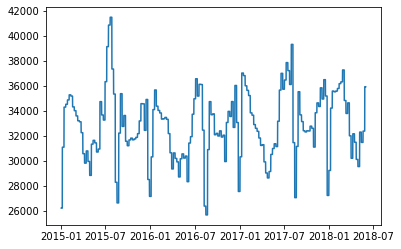

In [21]:
plt.plot(tP_res_W)

In [22]:
tP_res_W_roll_60D = tP_res_W.rolling('60D').mean()

In [23]:
tP_res_W_roll_60D.loc[tP_res_W_roll_60D['Megawatt'] < 29000, 'Megawatt'] = 29000

In [24]:
len(tP_res_W_roll_60D)

29928

(28598.140054563493, 37439.058854166666)

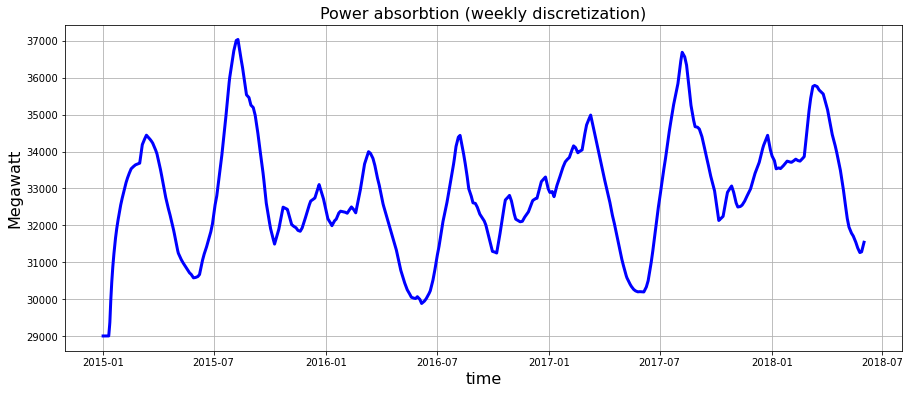

In [25]:
fig, ax = plt.subplots(1, figsize=(15,6))
ax.plot(tP_res_W_roll_60D['Megawatt'], color='blue', linewidth=3)
ax.set_title('Power absorbtion (weekly discretization)', fontsize=16)
ax.set_xlabel('time', size = 16)
ax.set_ylabel('Megawatt', size=16)
ax.set(facecolor ='#ffffff')
plt.rcParams["axes.edgecolor"] = "black"
#plt.legend(loc='upper left', fontsize=14)
plt.grid()
bottom, top = plt.ylim()
plt.ylim(bottom, top)

In [26]:
fig.savefig('../images/power_absorbtion_weekly.png', dpi=100)

In [27]:
fig.savefig('../images/power_absorbtion_weekly.svg')

In [28]:
top


37439.058854166666

#### Creating dataframe to be splitted into training and verification and test data

In [29]:
### X.drop(columns=['Megawatt', 'time_pos'], inplace = True)
#X.drop(columns=['Megawatt', 'seasonality', 'trend'], inplace = True)

In [30]:
#X

In [31]:
X['hour'] = y.index.hour + 1
X['day'] = y.index.day
X['dayOfWeek'] = y.index.dayofweek + 1
X['week'] = y.index.isocalendar().week
X['month'] = y.index.month
X['year']=y.index.year

#### Adding holidays column with the help of holidays package (Thanks Jens)

In [32]:
it_holiday = holidays.IT()


In [33]:
def is_holiday(d):
    if d in it_holiday:
        return 1
    else:
        return 0

In [34]:
X['holidays'] = [is_holiday(x) for x in y.index]

In [35]:
X.head()

,Megawatt,hour,day,dayOfWeek,week,month,year,holidays
time,,,,,,,,
2015-01-01 00:00:00+00:00,23126.0,1,1,4,1,1,2015,1
2015-01-01 01:00:00+00:00,21534.0,2,1,4,1,1,2015,1
2015-01-01 02:00:00+00:00,20219.0,3,1,4,1,1,2015,1
2015-01-01 03:00:00+00:00,19470.0,4,1,4,1,1,2015,1
2015-01-01 04:00:00+00:00,19485.0,5,1,4,1,1,2015,1


### Dividing into train, verification and test data

In [36]:
# training
y_train = y[start_date:'2018-05-31 23:00:00+00:00']
X_train = X[start_date:'2018-05-31 23:00:00+00:00']
print(y_train.shape, X_train.shape)


# validation
y_val = y['2018-06-01 00:00:00+00:00':corona_start]
X_val = X['2018-06-01 00:00:00+00:00':corona_start]
print(y_val.shape, X_val.shape)

# test
#y_test = y['2019-06-01 00:00:00+00:00':corona_start]
#X_test = X['2019-06-01 00:00:00+00:00':corona_start]
#print(y_test.shape, X_test.shape)


(29928,) (29928, 8)
(14689,) (14689, 8)


#### Plotting all data in one graphic

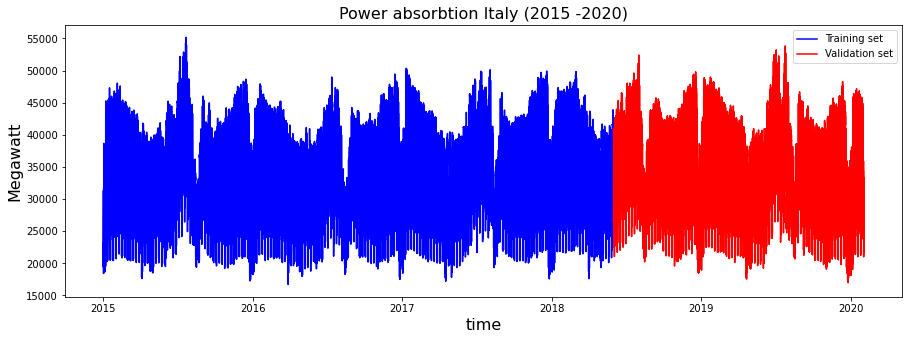

In [37]:
fig, ax = plt.subplots(1, figsize = (15,5))
plt.plot(y_train, color='blue', label='Training set')
plt.plot(y_val, color='red', label='Validation set')
ax.set_title('Power absorbtion Italy (2015 -2020)', fontsize=16)
ax.set_xlabel('time', size = 16)
ax.set_ylabel('Megawatt', size=16)
plt.legend(loc=1)
#plt.plot(y_test, color='green')

In [38]:
fig.savefig('../images/power_absorbtion.png', dpi=100)

In [39]:
fig.savefig('../images/power_absorbtion.svg')

### Feature engineering

In [40]:
interactionDeg2 = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

In [41]:
polyFeat_pipeline = make_pipeline(interactionDeg2, MinMaxScaler())

In [42]:
feat_eng = make_column_transformer(
    #(polyFeat_pipeline, ['hour', 'day']),
    #(polyFeat_pipeline, ['seasonality', 'month']),
    #(polyFeat_pipeline, ['day', 'month']),
    #(MinMaxScaler(), ['trend', 'week', 'month']),
    #(MinMaxScaler(), ['year']),
    #(StandardScaler(), ['trend']),
    #(KBinsDiscretizer(n_bins = 2, encode='ordinal', strategy='uniform'), ['week']),
    ####(polyFeat_pipeline, ['hour', 'dayOfWeek']),   
    ####(KBinsDiscretizer(n_bins = 4, encode='ordinal', strategy='uniform'), ['hour']),   
    ####(KBinsDiscretizer(n_bins = 2, encode='ordinal', strategy='uniform'), ['year']),
    (OneHotEncoder(sparse=True,handle_unknown='ignore'), ['hour', 'dayOfWeek', 'month', 'week', 'year']),
    ('passthrough', ['holidays']),
    remainder='drop'
    )


### Train the model with Ridge

In [43]:
model_pipe = make_pipeline(
    feat_eng,
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    Ridge(fit_intercept=True, alpha=15)
)

In [44]:
start_time = time.time()

In [45]:
# fit on the training data
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'dayOfWeek', 'month',
                                                   'week', 'year']),
                                                 ('passthrough', 'passthrough',
                                                  ['holidays'])])),
                ('ridge', Ridge(alpha=15))])

In [46]:
stop_time = time.time()
ridge_time = stop_time - start_time

#### Metrics definitions

In [47]:
def sMAPE (y, y_pred):
    abErr = abs(y - y_pred)
    y_plus_y_pred = y + y_pred
    sMAPE = np.mean(200 * abErr / y_plus_y_pred)
    return sMAPE

### Verification

In [48]:
# predict the validation
y_val_pred = model_pipe.predict(X_val)

# convert to pandas series in order to plot later
y_val_pred = pd.Series(y_val_pred, index=y_val.index)

In [49]:
y_val_pred

time
2018-06-01 00:00:00+00:00    26075.988342
2018-06-01 01:00:00+00:00    25429.719967
2018-06-01 02:00:00+00:00    25317.809550
2018-06-01 03:00:00+00:00    25848.539934
2018-06-01 04:00:00+00:00    27881.999538
                                 ...     
2020-02-02 20:00:00+00:00    28756.106647
2020-02-02 21:00:00+00:00    25703.831268
2020-02-02 22:00:00+00:00    22934.807761
2020-02-02 23:00:00+00:00    20770.306210
2020-02-03 00:00:00+00:00    27616.111317
Length: 14689, dtype: float64

#### evaluation with smape

In [50]:
my_smape = sMAPE(y_val, y_val_pred)
my_smape

7.719977056836245

In [51]:
my_MAE = metrics.mean_absolute_error(y_val, y_val_pred)
my_MAE

2392.996098518258

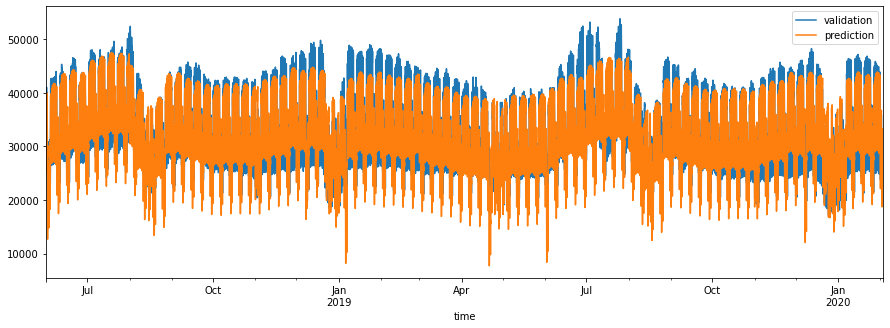

In [52]:
# plot the prediction vs the true values over the validation data
fig, ax = plt.subplots(1, figsize=(15,5))
ax = y_val.plot(label='validation')
y_val_pred.plot(ax=ax, label='prediction')
ax.legend()

In [53]:
remainder = y_val - y_val_pred

In [54]:
remainder

time
2018-06-01 00:00:00+00:00     907.011658
2018-06-01 01:00:00+00:00    1111.280033
2018-06-01 02:00:00+00:00    1365.190450
2018-06-01 03:00:00+00:00    1171.460066
2018-06-01 04:00:00+00:00    2328.000462
                                ...     
2020-02-02 20:00:00+00:00    1551.893353
2020-02-02 21:00:00+00:00    2340.168732
2020-02-02 22:00:00+00:00    2510.192239
2020-02-02 23:00:00+00:00    2347.693790
2020-02-03 00:00:00+00:00   -5926.111317
Length: 14689, dtype: float64

Text(0, 0.5, 'Megawatt')

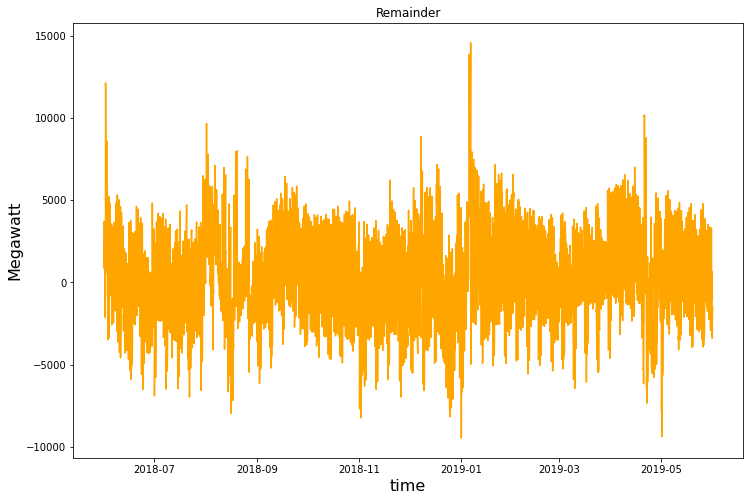

In [55]:
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(remainder.loc['2018-06-01':'2019-05-31'], color='orange')
ax.title.set_text('Remainder')
ax.set_xlabel('time', size = 16)
ax.set_ylabel('Megawatt', size=16)

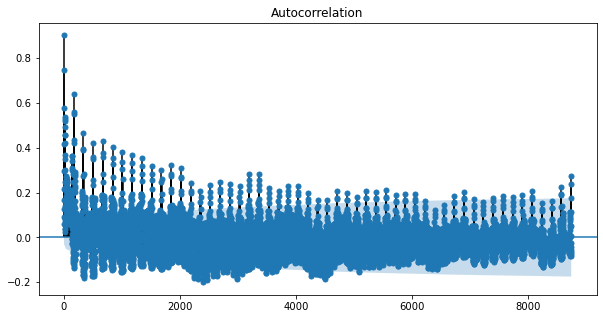

In [56]:

fig, ax = plt.subplots(figsize=(10,5))
#fig.set_size_inches(15,15)
p = plot_acf(remainder, zero=False, lags=24*7*52, ax=ax)

### Try the same forecast using fbprophet

In [57]:
m = Prophet()
type(m)

fbprophet.forecaster.Prophet

In [58]:
Y_train = pd.DataFrame({
    'ds' : y_train.index.tz_localize(None),# tz.localize(none) is to remove the timezone, else Prophet complains
    'y' : y_train
})


In [59]:
start_time= time.time()

In [60]:
m.fit(Y_train)

In [61]:
stop_time = time.time()
fbProph_time = stop_time - start_time

In [62]:
Y_val = pd.DataFrame({
    'ds' : y_val.index.tz_localize(None),
})
Y_val_proph = m.predict(Y_val)

In [63]:
Y_val_proph

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-01 00:00:00,34191.742628,22508.858394,30721.456059,34191.742628,34191.742628,-7678.756469,-7678.756469,-7678.756469,-8157.001699,...,2465.472375,2465.472375,2465.472375,-1987.227146,-1987.227146,-1987.227146,0.0,0.0,0.0,26512.986158
1,2018-06-01 01:00:00,34191.857191,21698.233616,29803.428687,34191.857191,34191.857191,-8486.185225,-8486.185225,-8486.185225,-8958.751285,...,2454.307549,2454.307549,2454.307549,-1981.741489,-1981.741489,-1981.741489,0.0,0.0,0.0,25705.671966
2,2018-06-01 02:00:00,34191.971755,21473.685771,29191.221617,34191.971755,34191.971755,-8822.137222,-8822.137222,-8822.137222,-9288.822250,...,2442.894650,2442.894650,2442.894650,-1976.209621,-1976.209621,-1976.209621,0.0,0.0,0.0,25369.834533
3,2018-06-01 03:00:00,34192.086319,22305.104118,30074.095201,34192.086319,34192.086319,-8105.264722,-8105.264722,-8105.264722,-8565.107363,...,2430.474255,2430.474255,2430.474255,-1970.631614,-1970.631614,-1970.631614,0.0,0.0,0.0,26086.821597
4,2018-06-01 04:00:00,34192.200882,24307.752628,32466.399272,34192.200882,34192.200882,-5800.604186,-5800.604186,-5800.604186,-6251.801480,...,2416.204836,2416.204836,2416.204836,-1965.007542,-1965.007542,-1965.007542,0.0,0.0,0.0,28391.596696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14684,2020-02-02 20:00:00,35873.994123,20111.280283,50277.806989,20862.130782,49889.276118,-983.068323,-983.068323,-983.068323,1275.058376,...,-4927.684777,-4927.684777,-4927.684777,2669.558077,2669.558077,2669.558077,0.0,0.0,0.0,34890.925799
14685,2020-02-02 21:00:00,35874.108686,16036.772869,46400.800613,20857.606240,49891.458586,-3983.214445,-3983.214445,-3983.214445,-2068.884604,...,-4575.205462,-4575.205462,-4575.205462,2660.875622,2660.875622,2660.875622,0.0,0.0,0.0,31890.894241
14686,2020-02-02 22:00:00,35874.223250,14476.021982,44072.285909,20853.081698,49893.641055,-6534.155556,-6534.155556,-6534.155556,-4974.007628,...,-4212.330499,-4212.330499,-4212.330499,2652.182571,2652.182571,2652.182571,0.0,0.0,0.0,29340.067694
14687,2020-02-02 23:00:00,35874.337814,12622.783689,42580.441585,20848.557156,49895.823524,-8145.557046,-8145.557046,-8145.557046,-6947.598979,...,-3841.437426,-3841.437426,-3841.437426,2643.479359,2643.479359,2643.479359,0.0,0.0,0.0,27728.780768


In [64]:
# extract the predictions
# The prediction is called yhat
y_val_proph = Y_val_proph['yhat']
y_val_proph.index = y_val.index
y_val_proph

time
2018-06-01 00:00:00+00:00    26512.986158
2018-06-01 01:00:00+00:00    25705.671966
2018-06-01 02:00:00+00:00    25369.834533
2018-06-01 03:00:00+00:00    26086.821597
2018-06-01 04:00:00+00:00    28391.596696
                                 ...     
2020-02-02 20:00:00+00:00    34890.925799
2020-02-02 21:00:00+00:00    31890.894241
2020-02-02 22:00:00+00:00    29340.067694
2020-02-02 23:00:00+00:00    27728.780768
2020-02-03 00:00:00+00:00    26887.296163
Name: yhat, Length: 14689, dtype: float64

In [65]:
# another feature is trend
y_val_proph_trend = Y_val_proph['trend']
y_val_proph_trend.index = y_val.index
y_val_proph_trend

time
2018-06-01 00:00:00+00:00    34191.742628
2018-06-01 01:00:00+00:00    34191.857191
2018-06-01 02:00:00+00:00    34191.971755
2018-06-01 03:00:00+00:00    34192.086319
2018-06-01 04:00:00+00:00    34192.200882
                                 ...     
2020-02-02 20:00:00+00:00    35873.994123
2020-02-02 21:00:00+00:00    35874.108686
2020-02-02 22:00:00+00:00    35874.223250
2020-02-02 23:00:00+00:00    35874.337814
2020-02-03 00:00:00+00:00    35874.452377
Name: trend, Length: 14689, dtype: float64

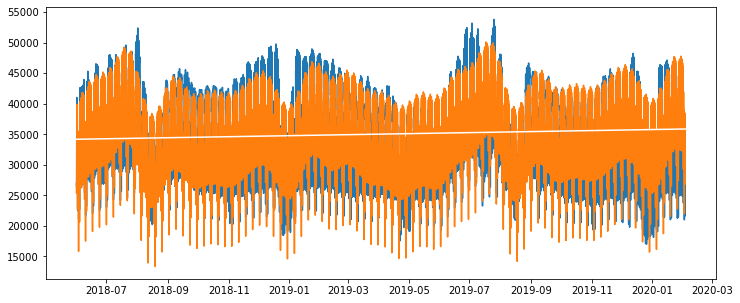

In [66]:
fig, ax = plt.subplots(1, figsize=(12,5))
plt.plot(y_val)
plt.plot(y_val_proph)
plt.plot(y_val_proph_trend, color='white')

In [67]:
proph_smape = sMAPE(y_val, y_val_proph)
proph_smape

8.816505059632624

In [68]:
proph_MAE = metrics.mean_absolute_error(y_val, y_val_proph)
proph_MAE

2827.848870681472

In [69]:
x_smape = ['my_smape', 'proph_smape']
smapes = [my_smape, proph_smape]

x_MAE = ['my_MAE', 'proph_MAE']
MAEs = [my_MAE, proph_MAE]

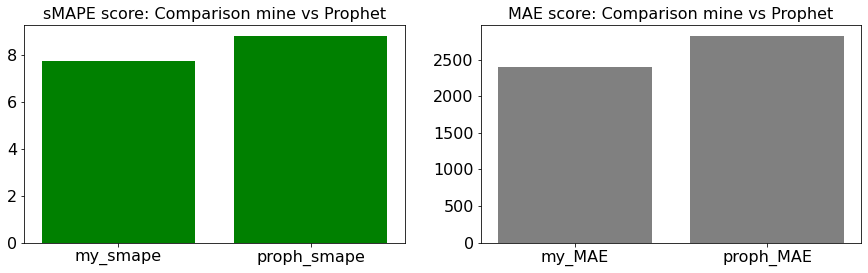

In [70]:
fig, axs = plt.subplots(1,2, figsize = (15,4))
axs[0].bar(x_smape,smapes, color='green')
axs[1].bar(x_MAE, MAEs, color='grey')
axs[0].set_title('sMAPE score: Comparison mine vs Prophet', fontsize=16)
axs[1].set_title('MAE score: Comparison mine vs Prophet', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)

### prediction with RNN

In [71]:
import tensorflow.keras as keras

In [72]:
X.shape[0]

44617

In [73]:
X[:]

,Megawatt,hour,day,dayOfWeek,week,month,year,holidays
time,,,,,,,,
2015-01-01 00:00:00+00:00,23126.0,1,1,4,1,1,2015,1
2015-01-01 01:00:00+00:00,21534.0,2,1,4,1,1,2015,1
2015-01-01 02:00:00+00:00,20219.0,3,1,4,1,1,2015,1
2015-01-01 03:00:00+00:00,19470.0,4,1,4,1,1,2015,1
2015-01-01 04:00:00+00:00,19485.0,5,1,4,1,1,2015,1
...,...,...,...,...,...,...,...,...
2020-02-02 20:00:00+00:00,30308.0,21,2,7,5,2,2020,0
2020-02-02 21:00:00+00:00,28044.0,22,2,7,5,2,2020,0
2020-02-02 22:00:00+00:00,25445.0,23,2,7,5,2,2020,0


In [74]:
y

time
2015-01-01 00:00:00+00:00    23126.0
2015-01-01 01:00:00+00:00    21534.0
2015-01-01 02:00:00+00:00    20219.0
2015-01-01 03:00:00+00:00    19470.0
2015-01-01 04:00:00+00:00    19485.0
                              ...   
2020-02-02 20:00:00+00:00    30308.0
2020-02-02 21:00:00+00:00    28044.0
2020-02-02 22:00:00+00:00    25445.0
2020-02-02 23:00:00+00:00    23118.0
2020-02-03 00:00:00+00:00    21690.0
Name: Megawatt, Length: 44617, dtype: float64

In [75]:
split_fraction = 0.67078
train_split = int(split_fraction * X.shape[0])
step = 1

In [76]:
train_split

29928

In [77]:
past = 120
future = 24
batch_size = 256 ##128
epochs = 40 ##20

In [78]:
def normalize(data, train_split):
    diff = data - data[:train_split].min()
    max_min = data[:train_split].max() - data[:train_split].min()
    return diff/max_min

In [79]:
X_features = X[['Megawatt', 'holidays']]
X_features.shape

(44617, 2)

In [80]:
X_features

,Megawatt,holidays
time,,
2015-01-01 00:00:00+00:00,23126.0,1
2015-01-01 01:00:00+00:00,21534.0,1
2015-01-01 02:00:00+00:00,20219.0,1
2015-01-01 03:00:00+00:00,19470.0,1
2015-01-01 04:00:00+00:00,19485.0,1
...,...,...
2020-02-02 20:00:00+00:00,30308.0,0
2020-02-02 21:00:00+00:00,28044.0,0
2020-02-02 22:00:00+00:00,25445.0,0


In [81]:
normalized_power = normalize(X_features['Megawatt'], train_split)

In [82]:
d = {'Megawatt': normalized_power, 'holidays': X_features['holidays']}

In [83]:
X_features = pd.DataFrame(data=d)

In [84]:
X_features

,Megawatt,holidays
time,,
2015-01-01 00:00:00+00:00,0.166749,1
2015-01-01 01:00:00+00:00,0.125335,1
2015-01-01 02:00:00+00:00,0.091127,1
2015-01-01 03:00:00+00:00,0.071642,1
2015-01-01 04:00:00+00:00,0.072032,1
...,...,...
2020-02-02 20:00:00+00:00,0.353581,0
2020-02-02 21:00:00+00:00,0.294685,0
2020-02-02 22:00:00+00:00,0.227075,0


In [85]:
train_data = X_features[:train_split]
val_data = X_features[train_split+1:]

In [86]:
train_data

,Megawatt,holidays
time,,
2015-01-01 00:00:00+00:00,0.166749,1
2015-01-01 01:00:00+00:00,0.125335,1
2015-01-01 02:00:00+00:00,0.091127,1
2015-01-01 03:00:00+00:00,0.071642,1
2015-01-01 04:00:00+00:00,0.072032,1
...,...,...
2018-05-31 19:00:00+00:00,0.570224,0
2018-05-31 20:00:00+00:00,0.493926,0
2018-05-31 21:00:00+00:00,0.417133,0


#### Train dataset

In [87]:
# Train dataset labels start from past 
start = past + future
# train data labels end at train_split 
end = train_split 
print(end-start)
x_train = train_data.iloc[:train_split - past -future].values
y_train = train_data.iloc[start:end][['Megawatt']]
sequence_length = int(past/step)

29784


In [88]:
x_train.shape

(29784, 2)

In [89]:
y_train.shape

(29784, 1)

In [90]:
x_train.shape

(29784, 2)

In [91]:
y_train = np.array(y_train)
y_train.shape

(29784, 1)

In [92]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x_train,
        y_train,
        sequence_length = sequence_length,
        sampling_rate = step,
        batch_size = batch_size,
)

In [93]:
type(dataset_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [94]:
dataset_train

<BatchDataset shapes: ((None, None, 2), (None, 1)), types: (tf.float64, tf.float64)>

#### Validation dataset

In [95]:
val_data.shape

(14688, 2)

In [96]:
X_features.shape

(44617, 2)

In [97]:
type(X_features)

pandas.core.frame.DataFrame

In [98]:
val_start = 0
val_end = len(val_data)

x_val = X_features[train_split-past -future + 1:-past-future]
y_val = val_data.iloc[val_start:end][['Megawatt']]

In [99]:
print(x_val.shape)
print(y_val.shape)
print(len(val_data))

(14688, 2)
(14688, 1)
14688


In [100]:
print(type(x_val), type(y_val))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [101]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x_val,
        y_val,
        sequence_length = sequence_length,
        sampling_rate = step,
        batch_size = batch_size)


In [102]:
dataset_val

<BatchDataset shapes: ((None, None, 2), (None, 1)), types: (tf.float64, tf.float64)>

In [103]:
for x_, y_ in dataset_train.take(1):
    print(x_[0])

tf.Tensor(
[[0.16674904 1.        ]
 [0.12533493 1.        ]
 [0.09112666 1.        ]
 [0.07164226 1.        ]
 [0.07203247 1.        ]
 [0.09450847 1.        ]
 [0.10402955 1.        ]
 [0.11383679 1.        ]
 [0.15764418 1.        ]
 [0.19580656 1.        ]
 [0.23113343 1.        ]
 [0.23605005 1.        ]
 [0.19596264 1.        ]
 [0.17429307 1.        ]
 [0.18209724 1.        ]
 [0.2260347  1.        ]
 [0.34002757 1.        ]
 [0.37017767 1.        ]
 [0.38092141 1.        ]
 [0.36146302 1.        ]
 [0.32392498 1.        ]
 [0.2638589  1.        ]
 [0.1925028  1.        ]
 [0.1262194  1.        ]
 [0.07929034 0.        ]
 [0.05304232 0.        ]
 [0.04411956 0.        ]
 [0.04791759 0.        ]
 [0.08048698 0.        ]
 [0.1602976  0.        ]
 [0.24645561 0.        ]
 [0.32093338 0.        ]
 [0.38549986 0.        ]
 [0.39249759 0.        ]
 [0.38448532 0.        ]
 [0.36708202 0.        ]
 [0.33578731 0.        ]
 [0.34882027 0.        ]
 [0.37811191 0.        ]
 [0.43391171 0

In [104]:
y

time
2015-01-01 00:00:00+00:00    23126.0
2015-01-01 01:00:00+00:00    21534.0
2015-01-01 02:00:00+00:00    20219.0
2015-01-01 03:00:00+00:00    19470.0
2015-01-01 04:00:00+00:00    19485.0
                              ...   
2020-02-02 20:00:00+00:00    30308.0
2020-02-02 21:00:00+00:00    28044.0
2020-02-02 22:00:00+00:00    25445.0
2020-02-02 23:00:00+00:00    23118.0
2020-02-03 00:00:00+00:00    21690.0
Name: Megawatt, Length: 44617, dtype: float64

#### Define inputs and outputs

In [105]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print('Input shape', inputs.numpy().shape)
print('Target shape', targets.numpy().shape)

Input shape (256, 120, 2)
Target shape (256, 1)


In [106]:
inputs.shape

TensorShape([256, 120, 2])

### Training

In [107]:
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])))
lstm_model.add(keras.layers.LSTM(64, 
                                 dropout=0.2,
                                 recurrent_dropout=0.2,
                                 return_sequences=True))

#lstm_model.add(keras.layers.BatchNormalization())

lstm_model.add(keras.layers.LSTM(64, 
                                 dropout=0.2,
                                 recurrent_dropout=0.2,
                                 return_sequences=False))

#lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Flatten())
#lstm.model.add(keras.layers.Dense(64))
#lstm_model.add(keras.layers.BatchNormalization())

lstm_model.add(keras.layers.Dense(1))

lstm_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mae',
    metrics=[keras.metrics.MeanAbsoluteError()])

In [108]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 64)           17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 50,241
Trainable params: 50,241
Non-trainable params: 0
_________________________________________________________________


#### Define callbacks: 
* EarlyStopping to avoid overfitting
* ModelCheckpoint to save the best model

In [109]:
path_checkpoint = "../models/lstm_ckpt/lstm.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0
)

lstm_ckpt = keras.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    filepath = path_checkpoint,
    verbose=1,
    save_weigths_only=True,
    save_best_only=True,
)

csv_logger = keras.callbacks.CSVLogger('../models/lstm_log/lstm.log', separator=',', append=False)

#### Training the model

In [110]:
start_time = time.time()

In [111]:
#Reactivate this if you want train the model. Else load a pretrained model... see down
lstm_history = lstm_model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[lstm_ckpt, csv_logger],
)

Epoch 1/40
116/116 [==============================] - 61s 491ms/step - loss: 0.2040 - mean_absolute_error: 0.2040 - val_loss: 0.1382 - val_mean_absolute_error: 0.1382

Epoch 00001: val_loss improved from inf to 0.13819, saving model to ../models/lstm_ckpt/lstm.h5
Epoch 2/40
116/116 [==============================] - 57s 494ms/step - loss: 0.1424 - mean_absolute_error: 0.1424 - val_loss: 0.1149 - val_mean_absolute_error: 0.1149

Epoch 00002: val_loss improved from 0.13819 to 0.11486, saving model to ../models/lstm_ckpt/lstm.h5
Epoch 3/40
116/116 [==============================] - 57s 495ms/step - loss: 0.1203 - mean_absolute_error: 0.1203 - val_loss: 0.1068 - val_mean_absolute_error: 0.1068

Epoch 00003: val_loss improved from 0.11486 to 0.10679, saving model to ../models/lstm_ckpt/lstm.h5
Epoch 4/40
116/116 [==============================] - 58s 498ms/step - loss: 0.1138 - mean_absolute_error: 0.1138 - val_loss: 0.1044 - val_mean_absolute_error: 0.1044

Epoch 00004: val_loss improved f

116/116 [==============================] - 57s 488ms/step - loss: 0.0634 - mean_absolute_error: 0.0634 - val_loss: 0.0471 - val_mean_absolute_error: 0.0471

Epoch 00034: val_loss improved from 0.05133 to 0.04707, saving model to ../models/lstm_ckpt/lstm.h5
Epoch 35/40
116/116 [==============================] - 57s 488ms/step - loss: 0.0628 - mean_absolute_error: 0.0628 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521

Epoch 00035: val_loss did not improve from 0.04707
Epoch 36/40
116/116 [==============================] - 57s 491ms/step - loss: 0.0625 - mean_absolute_error: 0.0625 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545

Epoch 00036: val_loss did not improve from 0.04707
Epoch 37/40
116/116 [==============================] - 57s 487ms/step - loss: 0.0637 - mean_absolute_error: 0.0637 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498

Epoch 00037: val_loss did not improve from 0.04707
Epoch 38/40
116/116 [==============================] - 56s 486ms/step - loss: 0.060

In [112]:
stop_time = time.time()
lstm_time = stop_time-start_time

### Visualize loss

In [113]:
def visualize_loss_MAE(history):
    val_loss = history.history["val_loss"]
    val_mae = history.history["val_mean_absolute_error"]
    epochs = range(len(val_loss))
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(epochs, val_loss, label="Validation loss")
    ax[1].plot(epochs, val_mae, label="Validation MAE")
    ax[0].set_title('Validation loss')
    ax[1].set_title('Validation Mean Absolute Error')
    ax[0].set_xlabel('epochs')
    ax[1].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('MAE')
    
    
#visualize_loss_MAE(history)

### Prediction

In [114]:
data = np.array(x_val)[120:240,:]

In [115]:
data=data.reshape(1, 120, 2)

In [116]:
data.shape

(1, 120, 2)

In [117]:
lstm_model.predict(data)

array([[0.2329379]], dtype=float32)

In [118]:
data.shape

(1, 120, 2)

In [119]:
data = data.reshape(1, 120, 2)

In [120]:
data.shape

(1, 120, 2)

In [121]:
data

array([[[0.26414505, 0.        ],
        [0.26528966, 0.        ],
        [0.27985744, 0.        ],
        [0.36830467, 0.        ],
        [0.51164122, 0.        ],
        [0.62553003, 0.        ],
        [0.66803673, 0.        ],
        [0.67087225, 0.        ],
        [0.67422804, 0.        ],
        [0.62181005, 0.        ],
        [0.60953149, 0.        ],
        [0.63442678, 0.        ],
        [0.65039931, 0.        ],
        [0.66036263, 0.        ],
        [0.62670066, 0.        ],
        [0.59891782, 0.        ],
        [0.59189407, 0.        ],
        [0.57449078, 0.        ],
        [0.5702245 , 0.        ],
        [0.49392576, 0.        ],
        [0.41713275, 0.        ],
        [0.34208267, 0.        ],
        [0.29192789, 0.        ],
        [0.26708462, 0.        ],
        [0.25558648, 0.        ],
        [0.25928046, 0.        ],
        [0.26804714, 0.        ],
        [0.35103145, 0.        ],
        [0.48903514, 0.        ],
        [0.595

In [122]:
tar =np.array(y_val['Megawatt'][120])

In [123]:
tar

array(0.25696522)

In [124]:
tar = tar.reshape(1,)

In [125]:
data[0,:,:]

array([[0.26414505, 0.        ],
       [0.26528966, 0.        ],
       [0.27985744, 0.        ],
       [0.36830467, 0.        ],
       [0.51164122, 0.        ],
       [0.62553003, 0.        ],
       [0.66803673, 0.        ],
       [0.67087225, 0.        ],
       [0.67422804, 0.        ],
       [0.62181005, 0.        ],
       [0.60953149, 0.        ],
       [0.63442678, 0.        ],
       [0.65039931, 0.        ],
       [0.66036263, 0.        ],
       [0.62670066, 0.        ],
       [0.59891782, 0.        ],
       [0.59189407, 0.        ],
       [0.57449078, 0.        ],
       [0.5702245 , 0.        ],
       [0.49392576, 0.        ],
       [0.41713275, 0.        ],
       [0.34208267, 0.        ],
       [0.29192789, 0.        ],
       [0.26708462, 0.        ],
       [0.25558648, 0.        ],
       [0.25928046, 0.        ],
       [0.26804714, 0.        ],
       [0.35103145, 0.        ],
       [0.48903514, 0.        ],
       [0.59501574, 0.        ],
       [0.

In [126]:
#data.shape

In [127]:
lstm_model.predict(data).shape

(1, 1)

In [128]:
def plot_res(data, target, model, delta):
    labels = ["Past history", "True", "Predicted"]
    marker = [".-", "bo", "ro"]
    time_steps = list(range(-data.shape[1], 0))
    if delta:
        future = delta
    else:
        future = 0
    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(time_steps, data[0,:,0], marker[0], markersize=10, label=labels[0])
    plt.plot(future, target[0], marker[1], markersize=10, label=labels[1], color="black", fillstyle='none')
    plt.plot(future, model.predict(data)[0], marker[2], markersize=8, label=labels[2])
    plt.legend(loc=4) #4 means "lower right"
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time step (1h)")
    plt.ylabel("Megawatt")
    print(time_steps)

[-120, -119, -118, -117, -116, -115, -114, -113, -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102, -101, -100, -99, -98, -97, -96, -95, -94, -93, -92, -91, -90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


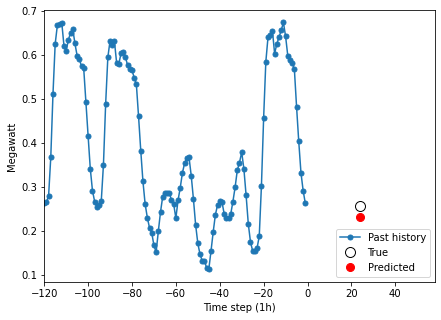

In [129]:
plot_res(data, tar, lstm_model, 24)

In [130]:
y_val.head()

,Megawatt
time,
2018-06-01 01:00:00+00:00,0.255586
2018-06-01 02:00:00+00:00,0.259280
2018-06-01 03:00:00+00:00,0.268047
2018-06-01 04:00:00+00:00,0.351031
2018-06-01 05:00:00+00:00,0.489035


In [131]:
print(len(y_val), len(x_val))

14688 14688


In [132]:
x_val

,Megawatt,holidays
time,,
2018-05-26 01:00:00+00:00,0.208111,0
2018-05-26 02:00:00+00:00,0.206082,0
2018-05-26 03:00:00+00:00,0.195000,0
2018-05-26 04:00:00+00:00,0.220338,0
2018-05-26 05:00:00+00:00,0.303270,0
...,...,...
2020-01-27 20:00:00+00:00,0.560677,0
2020-01-27 21:00:00+00:00,0.452538,0
2020-01-27 22:00:00+00:00,0.362426,0


In [133]:
def calculate_predictions(x_val, y_val, model, model_name='predicted', step=1):
    '''x_val and y_val are DataFrames, model is a DL model, step is an int (frequrncy of plot).
        Returns a list of tuples (target, predicted)'''
    #datas = []
    datas = []
    for i in range(0,len(x_val)-past-future,step):
        data = np.array(x_val)[i:i+past, :]
        data = data.reshape(1,past,2)
        tar =np.array(y_val['Megawatt'][i])
        date = y_val.index[i]
        pred = model.predict(data)[0]
        datas.append([date, tar, pred.reshape(-1)[0]])
    datas_df = pd.DataFrame(datas)
    datas_df = datas_df.set_index(0)
    datas_df.columns = ['target', model_name]
    datas_df.index.rename('date', inplace=True)
    return datas_df
    
    

In [134]:
datas_df = calculate_predictions(x_val, y_val, lstm_model, 'lstm_pred')

In [135]:
datas_df

,target,lstm_pred
date,,
2018-06-01 01:00:00+00:00,0.2555864831820192,0.208692
2018-06-01 02:00:00+00:00,0.25928045576337766,0.223659
2018-06-01 03:00:00+00:00,0.26804713717124945,0.271165
2018-06-01 04:00:00+00:00,0.35103145079472436,0.364148
2018-06-01 05:00:00+00:00,0.48903514476730575,0.491196
...,...,...
2020-01-27 20:00:00+00:00,0.5606774017325251,0.498993
2020-01-27 21:00:00+00:00,0.45253765510782756,0.401604
2020-01-27 22:00:00+00:00,0.36242553523581594,0.316407


In [136]:
datas_df.shape

(14544, 2)

In [137]:
#datas_df.index.date

In [138]:
### Prepare the results of ML for the comparison with DL

In [139]:
max_train_value = y[0:train_split].max()
max_train_value

55157.0

In [140]:
min_train_value = y[0:train_split].min()
min_train_value

16716.0

In [141]:
def norm_val(y_pred_series, max_val, min_val):
    diff = y_pred_series - min_val
    max_min = max_val-min_val
    return diff/max_min

#### Add Ridge model results

In [142]:
y_val_pred_norm = norm_val(y_val_pred, max_train_value, min_train_value)

In [143]:
y_val_pred_norm

time
2018-06-01 00:00:00+00:00    0.243490
2018-06-01 01:00:00+00:00    0.226678
2018-06-01 02:00:00+00:00    0.223767
2018-06-01 03:00:00+00:00    0.237573
2018-06-01 04:00:00+00:00    0.290471
                               ...   
2020-02-02 20:00:00+00:00    0.313210
2020-02-02 21:00:00+00:00    0.233808
2020-02-02 22:00:00+00:00    0.161775
2020-02-02 23:00:00+00:00    0.105468
2020-02-03 00:00:00+00:00    0.283554
Length: 14689, dtype: float64

In [144]:
y_val_pred_norm = y_val_pred_norm[1:]

In [145]:
y_val_pred_norm

time
2018-06-01 01:00:00+00:00    0.226678
2018-06-01 02:00:00+00:00    0.223767
2018-06-01 03:00:00+00:00    0.237573
2018-06-01 04:00:00+00:00    0.290471
2018-06-01 05:00:00+00:00    0.392562
                               ...   
2020-02-02 20:00:00+00:00    0.313210
2020-02-02 21:00:00+00:00    0.233808
2020-02-02 22:00:00+00:00    0.161775
2020-02-02 23:00:00+00:00    0.105468
2020-02-03 00:00:00+00:00    0.283554
Length: 14688, dtype: float64

In [146]:
len(y_val_pred_norm)

14688

In [147]:
#y_val_pred_norm.index[0]

In [148]:
def select_res(norm_pred, step=1):
    res = []
    for i in range(0,len(norm_pred)-past-future,step):
        date = norm_pred.index[i]
        res.append([date, norm_pred[i]])
    datas_df = pd.DataFrame(res)
    datas_df = datas_df.set_index(0)
    datas_df.columns = ['pred']
    datas_df.index.rename('date', inplace=True)
    return datas_df
    

In [149]:
y_val_pred_norm_df = select_res(y_val_pred_norm)
y_val_pred_norm_df

,pred
date,
2018-06-01 01:00:00+00:00,0.226678
2018-06-01 02:00:00+00:00,0.223767
2018-06-01 03:00:00+00:00,0.237573
2018-06-01 04:00:00+00:00,0.290471
2018-06-01 05:00:00+00:00,0.392562
...,...
2020-01-27 20:00:00+00:00,0.539850
2020-01-27 21:00:00+00:00,0.460449
2020-01-27 22:00:00+00:00,0.388416


In [150]:
y_val_pred_norm_df.shape

(14544, 1)

In [151]:
datas_df['Ridge_pred'] = y_val_pred_norm_df['pred'].values

In [152]:
datas_df

,target,lstm_pred,Ridge_pred
date,,,
2018-06-01 01:00:00+00:00,0.2555864831820192,0.208692,0.226678
2018-06-01 02:00:00+00:00,0.25928045576337766,0.223659,0.223767
2018-06-01 03:00:00+00:00,0.26804713717124945,0.271165,0.237573
2018-06-01 04:00:00+00:00,0.35103145079472436,0.364148,0.290471
2018-06-01 05:00:00+00:00,0.48903514476730575,0.491196,0.392562
...,...,...,...
2020-01-27 20:00:00+00:00,0.5606774017325251,0.498993,0.539850
2020-01-27 21:00:00+00:00,0.45253765510782756,0.401604,0.460449
2020-01-27 22:00:00+00:00,0.36242553523581594,0.316407,0.388416


#### Add fbprohet model results

In [153]:
y_val_proph_norm = norm_val(y_val_proph, max_train_value, min_train_value)
y_val_proph_norm = y_val_proph_norm[1:]
y_val_proph_norm_df = select_res(y_val_proph_norm)

In [154]:
y_val_proph_norm_df

,pred
date,
2018-06-01 01:00:00+00:00,0.233856
2018-06-01 02:00:00+00:00,0.225120
2018-06-01 03:00:00+00:00,0.243772
2018-06-01 04:00:00+00:00,0.303728
2018-06-01 05:00:00+00:00,0.399395
...,...
2020-01-27 20:00:00+00:00,0.682721
2020-01-27 21:00:00+00:00,0.598434
2020-01-27 22:00:00+00:00,0.525097


In [155]:
datas_df['fbProphet_pred'] = y_val_proph_norm_df['pred'].values

In [156]:
datas_df

,target,lstm_pred,Ridge_pred,fbProphet_pred
date,,,,
2018-06-01 01:00:00+00:00,0.2555864831820192,0.208692,0.226678,0.233856
2018-06-01 02:00:00+00:00,0.25928045576337766,0.223659,0.223767,0.225120
2018-06-01 03:00:00+00:00,0.26804713717124945,0.271165,0.237573,0.243772
2018-06-01 04:00:00+00:00,0.35103145079472436,0.364148,0.290471,0.303728
2018-06-01 05:00:00+00:00,0.48903514476730575,0.491196,0.392562,0.399395
...,...,...,...,...
2020-01-27 20:00:00+00:00,0.5606774017325251,0.498993,0.539850,0.682721
2020-01-27 21:00:00+00:00,0.45253765510782756,0.401604,0.460449,0.598434
2020-01-27 22:00:00+00:00,0.36242553523581594,0.316407,0.388416,0.525097


### 1D Convolutional NN

In [157]:
dataset_train

<BatchDataset shapes: ((None, None, 2), (None, 1)), types: (tf.float64, tf.float64)>

In [158]:
dataset_val

<BatchDataset shapes: ((None, None, 2), (None, 1)), types: (tf.float64, tf.float64)>

In [159]:
CNN_model = keras.Sequential()
CNN_model.add(keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])))
CNN_model.add(keras.layers.Conv1D(
                            32,
                            5,
                            activation='relu',
                            padding = 'same'
                            )
)

CNN_model.add(keras.layers.MaxPooling1D(3))

CNN_model.add(keras.layers.Conv1D(
                            32,
                            5,
                            activation='relu',
                            padding = 'same'
                            )
)

CNN_model.add(keras.layers.MaxPooling1D(3))

CNN_model.add(keras.layers.Conv1D(
                            64,
                            5,
                            activation='relu',
                            padding = 'same'
                            )
)
#CNN_model.add(keras.layers.BatchNormalization()) ##

CNN_model.add(keras.layers.GlobalMaxPooling1D())
#CNN_model.add(keras.layers.MaxPooling1D(3))

#CNN_model.add(keras.layers.BatchNormalization()) ##


CNN_model.add(keras.layers.Flatten()) ##
#CNN_model.add(keras.layers.Dense(64)) ##
#CNN_model.add(keras.layers.BatchNormalization()) ##
CNN_model.add(keras.layers.Dense(1))

CNN_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mae',
    metrics=[keras.metrics.MeanAbsoluteError()])

In [160]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 120, 32)           352       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 32)            5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 64)            10304     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [161]:
path_checkpoint = "../models/CNN_ckpt/CNN.h5"

CNN_ckpt = keras.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    filepath = path_checkpoint,
    verbose=1,
    save_weigths_only=True,
    save_best_only=True,
)

csv_logger = keras.callbacks.CSVLogger('../models/CNN_log/CNN.log', separator=',', append=False)

In [162]:
start_time = time.time()

In [163]:
#Reactivate this if you want train the model. Else load a pretrained model... see down
CNN_history = CNN_model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[CNN_ckpt, csv_logger],
)

Epoch 1/40
116/116 [==============================] - 6s 45ms/step - loss: 0.2392 - mean_absolute_error: 0.2392 - val_loss: 0.0919 - val_mean_absolute_error: 0.0919

Epoch 00001: val_loss improved from inf to 0.09186, saving model to ../models/CNN_ckpt/CNN.h5
Epoch 2/40
116/116 [==============================] - 5s 45ms/step - loss: 0.0912 - mean_absolute_error: 0.0912 - val_loss: 0.0863 - val_mean_absolute_error: 0.0863

Epoch 00002: val_loss improved from 0.09186 to 0.08633, saving model to ../models/CNN_ckpt/CNN.h5
Epoch 3/40
116/116 [==============================] - 5s 44ms/step - loss: 0.0730 - mean_absolute_error: 0.0730 - val_loss: 0.0999 - val_mean_absolute_error: 0.0999

Epoch 00003: val_loss did not improve from 0.08633
Epoch 4/40
116/116 [==============================] - 5s 46ms/step - loss: 0.0774 - mean_absolute_error: 0.0774 - val_loss: 0.0824 - val_mean_absolute_error: 0.0824

Epoch 00004: val_loss improved from 0.08633 to 0.08243, saving model to ../models/CNN_ckpt/CN

116/116 [==============================] - 5s 47ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381

Epoch 00036: val_loss improved from 0.03858 to 0.03808, saving model to ../models/CNN_ckpt/CNN.h5
Epoch 37/40
116/116 [==============================] - 5s 46ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368

Epoch 00037: val_loss improved from 0.03808 to 0.03676, saving model to ../models/CNN_ckpt/CNN.h5
Epoch 38/40
116/116 [==============================] - 5s 46ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371

Epoch 00038: val_loss did not improve from 0.03676
Epoch 39/40
116/116 [==============================] - 5s 46ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393

Epoch 00039: val_loss did not improve from 0.03676
Epoch 40/40
116/116 [=========================

In [164]:
stop_time = time.time()
CNN_time = stop_time-start_time

In [165]:
CNN_df = calculate_predictions(x_val, y_val, CNN_model, 'CNN_pred')

In [166]:
CNN_df

,target,CNN_pred
date,,
2018-06-01 01:00:00+00:00,0.2555864831820192,0.248641
2018-06-01 02:00:00+00:00,0.25928045576337766,0.250571
2018-06-01 03:00:00+00:00,0.26804713717124945,0.271877
2018-06-01 04:00:00+00:00,0.35103145079472436,0.351662
2018-06-01 05:00:00+00:00,0.48903514476730575,0.485989
...,...,...
2020-01-27 20:00:00+00:00,0.5606774017325251,0.542601
2020-01-27 21:00:00+00:00,0.45253765510782756,0.427696
2020-01-27 22:00:00+00:00,0.36242553523581594,0.339929


### Add CNN results to dataframe

In [167]:
datas_df['CNN1D_pred'] = CNN_df['CNN_pred'].values

In [168]:
datas_df

,target,lstm_pred,Ridge_pred,fbProphet_pred,CNN1D_pred
date,,,,,
2018-06-01 01:00:00+00:00,0.2555864831820192,0.208692,0.226678,0.233856,0.248641
2018-06-01 02:00:00+00:00,0.25928045576337766,0.223659,0.223767,0.225120,0.250571
2018-06-01 03:00:00+00:00,0.26804713717124945,0.271165,0.237573,0.243772,0.271877
2018-06-01 04:00:00+00:00,0.35103145079472436,0.364148,0.290471,0.303728,0.351662
2018-06-01 05:00:00+00:00,0.48903514476730575,0.491196,0.392562,0.399395,0.485989
...,...,...,...,...,...
2020-01-27 20:00:00+00:00,0.5606774017325251,0.498993,0.539850,0.682721,0.542601
2020-01-27 21:00:00+00:00,0.45253765510782756,0.401604,0.460449,0.598434,0.427696
2020-01-27 22:00:00+00:00,0.36242553523581594,0.316407,0.388416,0.525097,0.339929


In [169]:
datas_df.to_csv("../data/datas_df.csv")

In [170]:
#dts = pd.read_csv("../data/datas_df.csv", index_col="date")

In [171]:
#dts

### GRU

In [172]:
gru_model = keras.Sequential()
gru_model.add(keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])))
gru_model.add(keras.layers.GRU(64, 
                                 dropout=0.1,
                                 return_sequences=True))
#gru_model.add(keras.layers.BatchNormalization())
#gru_model.add(keras.layers.GRU(32, 
#                                 dropout=0.2,
#                                 recurrent_dropout=0.2,
#                                 return_sequences=True))
gru_model.add(keras.layers.GRU(
                        64,
                        dropout=0.1))  ##32
gru_model.add(keras.layers.Flatten())
#gru_model.add(keras.layers.Dense(64))
#gru_model.add(keras.layers.BatchNormalization())
gru_model.add(keras.layers.Dense(1))

gru_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mae',
    metrics=[keras.metrics.MeanAbsoluteError()])

In [173]:
path_checkpoint = "../models/gru_ckpt/gru.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0
)

gru_ckpt = keras.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    filepath = path_checkpoint,
    verbose=1,
    save_weigths_only=True,
    save_best_only=True,
)

csv_logger = keras.callbacks.CSVLogger('../models/gru_log/gru.log', separator=',', append=False)

In [174]:
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 120, 64)           13056     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 38,081
Trainable params: 38,081
Non-trainable params: 0
_________________________________________________________________


In [175]:
start_time = time.time()

In [176]:
#Reactivate this if you want train the model. Else load a pretrained model... see down
gru_history = gru_model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[gru_ckpt, csv_logger],
)

Epoch 1/40
116/116 [==============================] - 41s 334ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1265 - val_mean_absolute_error: 0.1265

Epoch 00001: val_loss improved from inf to 0.12652, saving model to ../models/gru_ckpt/gru.h5
Epoch 2/40
116/116 [==============================] - 40s 341ms/step - loss: 0.1282 - mean_absolute_error: 0.1282 - val_loss: 0.1100 - val_mean_absolute_error: 0.1100

Epoch 00002: val_loss improved from 0.12652 to 0.11005, saving model to ../models/gru_ckpt/gru.h5
Epoch 3/40
116/116 [==============================] - 40s 343ms/step - loss: 0.1195 - mean_absolute_error: 0.1195 - val_loss: 0.1032 - val_mean_absolute_error: 0.1032

Epoch 00003: val_loss improved from 0.11005 to 0.10321, saving model to ../models/gru_ckpt/gru.h5
Epoch 4/40
116/116 [==============================] - 40s 347ms/step - loss: 0.1119 - mean_absolute_error: 0.1119 - val_loss: 0.1025 - val_mean_absolute_error: 0.1025

Epoch 00004: val_loss improved from 0.


Epoch 00035: val_loss improved from 0.06644 to 0.06437, saving model to ../models/gru_ckpt/gru.h5
Epoch 36/40
116/116 [==============================] - 40s 341ms/step - loss: 0.0408 - mean_absolute_error: 0.0408 - val_loss: 0.0681 - val_mean_absolute_error: 0.0681

Epoch 00036: val_loss did not improve from 0.06437
Epoch 37/40
116/116 [==============================] - 45s 385ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0655 - val_mean_absolute_error: 0.0655

Epoch 00037: val_loss did not improve from 0.06437
Epoch 38/40
116/116 [==============================] - 41s 353ms/step - loss: 0.0413 - mean_absolute_error: 0.0413 - val_loss: 0.0667 - val_mean_absolute_error: 0.0667

Epoch 00038: val_loss did not improve from 0.06437
Epoch 39/40
116/116 [==============================] - 41s 352ms/step - loss: 0.0404 - mean_absolute_error: 0.0404 - val_loss: 0.0626 - val_mean_absolute_error: 0.0626

Epoch 00039: val_loss improved from 0.06437 to 0.06264, saving model to 

In [177]:
stop_time = time.time()
GRU_time = stop_time-start_time

In [178]:
#gru_history

#### Calculate prediction GRU

In [179]:
GRU_df = calculate_predictions(x_val, y_val, gru_model, 'gru_pred')

In [180]:
# Add gru results to datas_df
datas_df['GRU_pred'] = GRU_df['gru_pred'].values

In [181]:
datas_df

,target,lstm_pred,Ridge_pred,fbProphet_pred,CNN1D_pred,GRU_pred
date,,,,,,
2018-06-01 01:00:00+00:00,0.2555864831820192,0.208692,0.226678,0.233856,0.248641,0.239757
2018-06-01 02:00:00+00:00,0.25928045576337766,0.223659,0.223767,0.225120,0.250571,0.251590
2018-06-01 03:00:00+00:00,0.26804713717124945,0.271165,0.237573,0.243772,0.271877,0.285465
2018-06-01 04:00:00+00:00,0.35103145079472436,0.364148,0.290471,0.303728,0.351662,0.337456
2018-06-01 05:00:00+00:00,0.48903514476730575,0.491196,0.392562,0.399395,0.485989,0.424924
...,...,...,...,...,...,...
2020-01-27 20:00:00+00:00,0.5606774017325251,0.498993,0.539850,0.682721,0.542601,0.517209
2020-01-27 21:00:00+00:00,0.45253765510782756,0.401604,0.460449,0.598434,0.427696,0.429624
2020-01-27 22:00:00+00:00,0.36242553523581594,0.316407,0.388416,0.525097,0.339929,0.363347


In [182]:
datas_df.iloc[144]['lstm_pred']

0.2115490883588791

In [183]:
datas_df.to_csv("../data/datas_df.csv")

### Evaluating smape and MAE

In [184]:
model_name = ['Ridge', 'fbProphet', 'LSTM', '1D_CNN' , 'GRU']

target_expanded = datas_df['target']*(max_train_value-min_train_value)+min_train_value


In [185]:
Ridge_pred_expanded = datas_df['Ridge_pred']*(max_train_value-min_train_value)+min_train_value
Ridge_MAE = metrics.mean_absolute_error(target_expanded, Ridge_pred_expanded)

Prophet_pred_expanded = datas_df['fbProphet_pred']*(max_train_value-min_train_value)+min_train_value
Prophet_MAE = metrics.mean_absolute_error(target_expanded, Prophet_pred_expanded)

LSTM_pred_expanded = datas_df['lstm_pred']*(max_train_value-min_train_value)+min_train_value
LSTM_MAE = metrics.mean_absolute_error(target_expanded, LSTM_pred_expanded)

CNN1D_pred_expanded = datas_df['CNN1D_pred']*(max_train_value-min_train_value)+min_train_value
CNN1D_MAE = metrics.mean_absolute_error(target_expanded, CNN1D_pred_expanded)

GRU_pred_expanded = datas_df['GRU_pred']*(max_train_value-min_train_value)+min_train_value
GRU_MAE = metrics.mean_absolute_error(target_expanded, GRU_pred_expanded)

In [186]:
Psm = sMAPE(target_expanded, Prophet_pred_expanded)
Psm

8.759961780250375

In [187]:
Csm =sMAPE(target_expanded, CNN1D_pred_expanded)
Csm

5.095399455452898

In [188]:
Rsm = sMAPE(target_expanded, Ridge_pred_expanded)
Rsm

7.728795561168496

In [189]:
Lsm = sMAPE(target_expanded, LSTM_pred_expanded)
Lsm

7.204956488816606

In [190]:
Gsm = sMAPE(target_expanded, GRU_pred_expanded)
Gsm

6.933869676657989

In [191]:
smapes = [Rsm, Psm, Lsm, Csm, Gsm]
smapes

[7.728795561168496,
 8.759961780250375,
 7.204956488816606,
 5.095399455452898,
 6.933869676657989]

Text(0, 0.5, 'Error %')

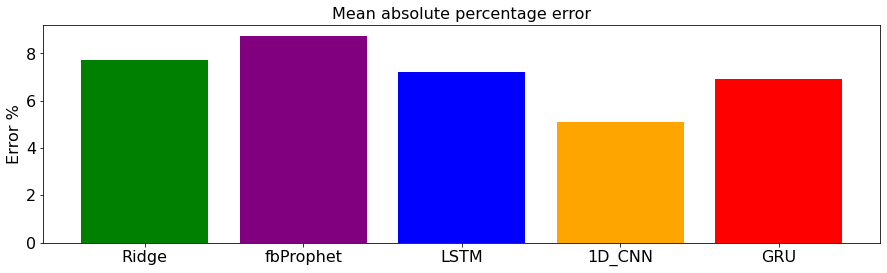

In [192]:
fig, ax = plt.subplots(figsize = (15,4))
ax.bar(model_name,smapes, color=['green', 'purple', 'blue', 'orange', 'red'])
ax.set_title('Mean absolute percentage error', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Error %', size=16)

In [193]:
# calculate time for computing
comp_times = [ridge_time, fbProph_time, lstm_time, CNN_time, GRU_time]
comp_times

[0.14760375022888184,
 47.16511940956116,
 2286.5039732456207,
 216.7905650138855,
 1606.4374554157257]

Text(0, 0.5, 'Minutes')

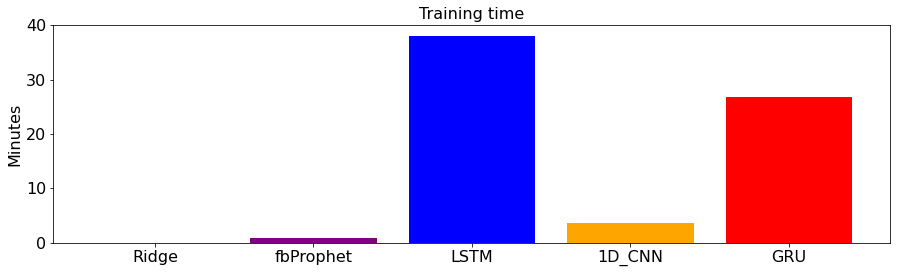

In [194]:
comp_times = np.array(comp_times)/60
fig, ax = plt.subplots(figsize = (15,4))
ax.bar(model_name,comp_times, color=['green', 'purple', 'blue', 'orange', 'red'])
ax.set_title('Training time', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Minutes', size=16)

In [195]:
ratio_perf_time = np.array(smapes)/np.array(comp_times)
ratio_perf_time

array([3.14170699e+03, 1.11437798e+01, 1.89064788e-01, 1.41022727e+00,
       2.58978138e-01])

Text(0, 0.5, 'Error %')

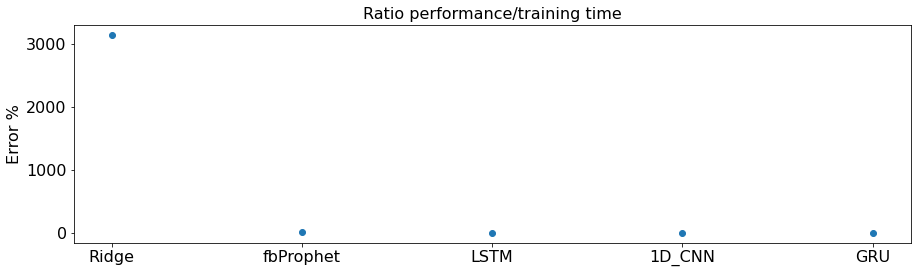

In [196]:
fig, ax = plt.subplots(figsize = (15,4))
ax.scatter(model_name,ratio_perf_time)#, color=['green', 'purple', 'blue', 'orange', 'red'])
ax.set_title('Ratio performance/training time', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Error %', size=16)

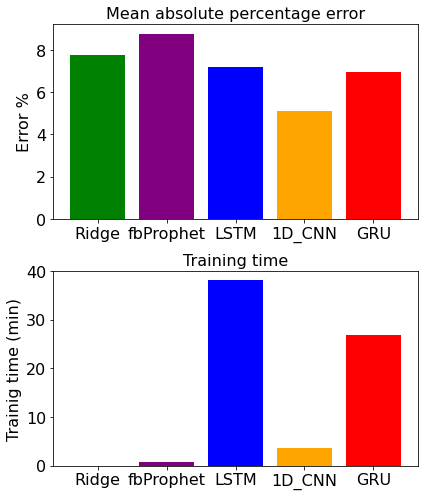

In [197]:
fig, axs = plt.subplots(2,1, figsize = (6,7))
axs[0].bar(model_name,smapes, color=['green', 'purple', 'blue', 'orange', 'red'])
axs[0].set_title('Mean absolute percentage error', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_ylabel('Error %', size=16)

axs[1].bar(model_name,comp_times, color=['green', 'purple', 'blue', 'orange', 'red'])
axs[1].set_title('Training time', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].set_ylabel('Trainig time (min)', size=16)

fig.tight_layout()

In [198]:
fig.savefig('../images/smape.png')

In [199]:
y_val

,Megawatt
time,
2018-06-01 01:00:00+00:00,0.255586
2018-06-01 02:00:00+00:00,0.259280
2018-06-01 03:00:00+00:00,0.268047
2018-06-01 04:00:00+00:00,0.351031
2018-06-01 05:00:00+00:00,0.489035
...,...
2020-02-02 20:00:00+00:00,0.353581
2020-02-02 21:00:00+00:00,0.294685
2020-02-02 22:00:00+00:00,0.227075


In [200]:
def plot_res_and_hist(x_val, y_val, datas_df, step=1000, future=24, past=120):
    labs = ["Past history", "True", "lstm", "Ridge", "fbProphet", "CNN_1D", "GRU"]
    marker = [".-", "bo", "bo", "g^", 'ms', 'cD', 'r+']
    for i in range(0, len(x_val)-past-future, step):   
        fig, ax = plt.subplots(figsize=(6,4))
        data = np.array(x_val)[i:i+past, :]
        data = data.reshape(1,past,2)
        tar = np.array(y_val["Megawatt"][i])
        time_steps = list(range(i,i+past))
        plt.plot(time_steps, data[0,:,0], marker[0], markersize=10, label=labs[0])
        plt.plot(i+past+future, tar, marker[1], markersize=10, label=labs[1], color="black", fillstyle='none',
                markeredgewidth=2)
        #for model in models:
        #    plt.plot(i+past+future, model.predict(data)[0], marker[2], markersize=8, label=labs[2])
        plt.plot(i+past+future, datas_df.iloc[i]['Ridge_pred'], marker[2], markersize=6, label=labs[2])
        plt.plot(i+past+future, datas_df.iloc[i]['fbProphet_pred'], marker[3], markersize=6, label=labs[3])
        plt.plot(i+past+future, datas_df.iloc[i]['lstm_pred'], marker[4], markersize=6, label=labs[4])
        plt.plot(i+past+future, datas_df.iloc[i]['CNN1D_pred'], marker[5], markersize=5, label=labs[5])
        plt.plot(i+past+future, datas_df.iloc[i]['GRU_pred'], marker[6], markersize=8, label=labs[6], 
                 markeredgewidth=1.3)
        plt.legend(bbox_to_anchor=(1.0, 0.7)) #4 means "lower right"
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels[0] = x_val.index.date[i]
        labels[6] = x_val.index.date[i+past+future]
        ax.set_xticklabels(labels)
        ax.set_xticks(np.arange(i,i+past+future,23.95))
        plt.xlabel("Time step")
        plt.ylabel("Megawatt (normalized)")
        fig.savefig('../images/fig_{}.png'.format(x_val.index.date[i+past+future]), dpi=100,bbox_inches='tight')
        

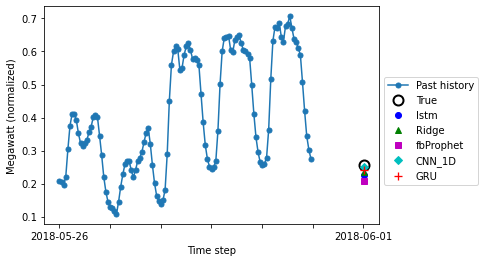

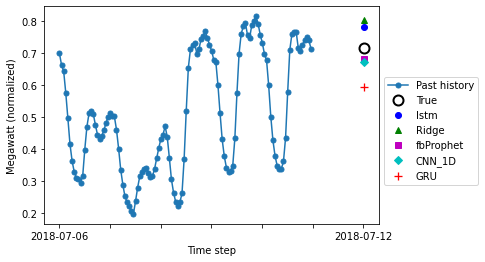

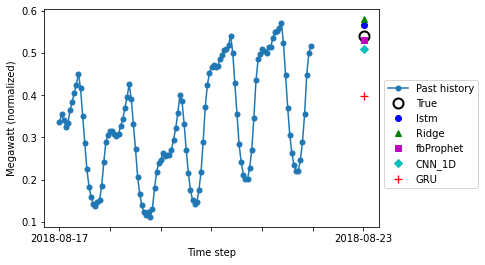

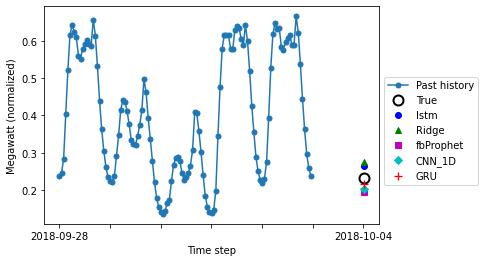

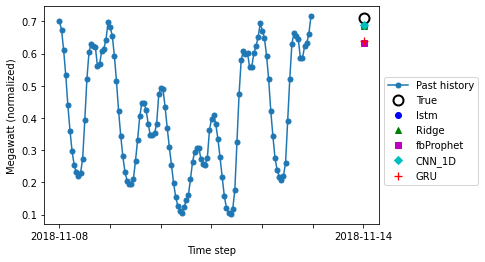

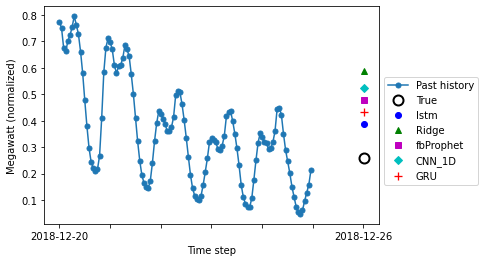

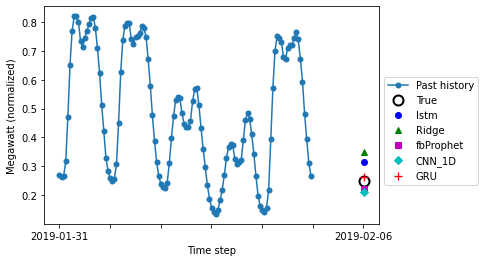

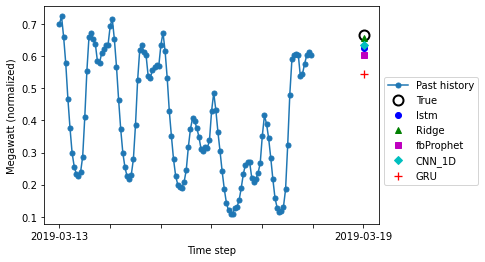

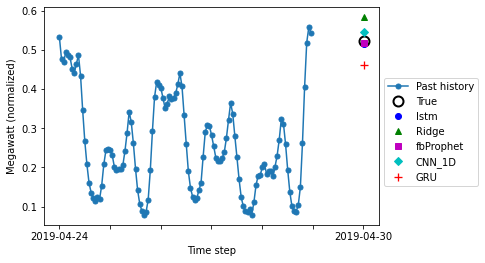

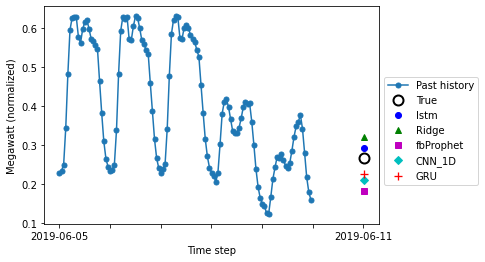

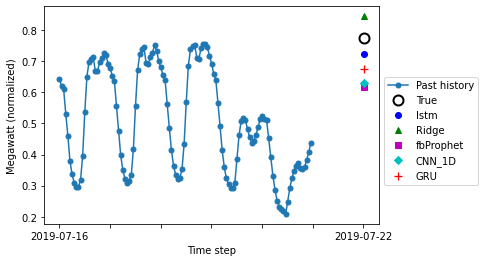

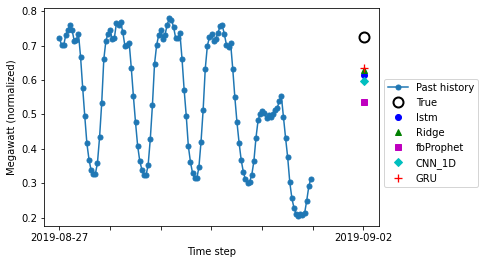

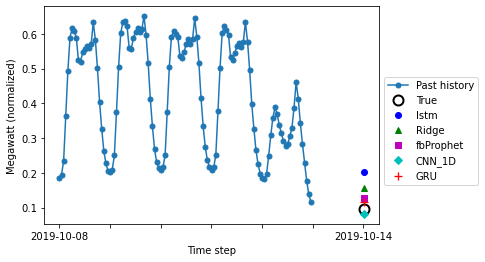

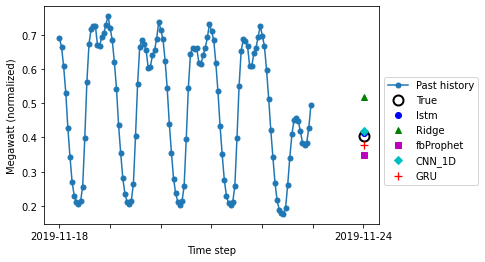

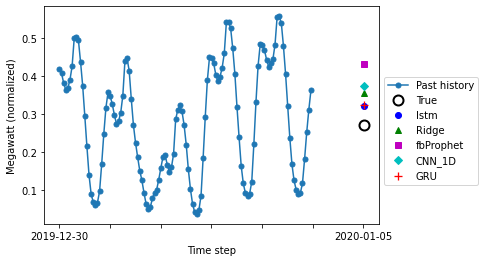

In [201]:
plot_res_and_hist(x_val, y_val, datas_df)

#### simpleRNN

In [202]:
simpleRNN_m = keras.models.Sequential()

In [203]:
simpleRNN_m.add(keras.layers.SimpleRNN(32))

In [204]:
simpleRNN_m.add(keras.layers.Dense(1))

In [205]:
simpleRNN_m.compile(
        optimizer = keras.optimizers.RMSprop(),
        loss = 'mae')

In [206]:
simpleRNN_m.

SyntaxError: invalid syntax (<ipython-input-206-982d10a088dc>, line 1)